In [3]:
import os, re
import pandas as pd
import numpy as np
from pyfaidx import Fasta #you will have to install this with "conda install pyfaidx"

#a helpful tip: in case you change your _config file while your notebook is running, 
#make sure to reload the _config module when you do, otherwise the variables will get stale
import importlib
import _config
importlib.reload(_config)
from _config import DATA_DIR, OUT_PLACE

from _configpatterns import REGRESSION_TRACK_FILES, CONFIGURATION_NAME, ALL_TRACK_FILES
from _configcompare import COMPARISON_FILES, CONFIGURATION_NAME 

#use your data directory to locate your data files
JEN_DATA_DIR = os.path.join(DATA_DIR,"jen")
COMPARE_DATA_DIR = os.path.join(DATA_DIR,"shibata")
PATTERN_DATA_DIR = os.path.join(DATA_DIR,"mouse")

OUT_DIR = os.path.join(OUT_PLACE,"eccdna1_firsttests")
if not os.path.isdir(OUT_DIR): os.makedirs(OUT_DIR)
    
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import argparse
import seaborn as sns

In [4]:
files = [rtf['filename'] for rtf in REGRESSION_TRACK_FILES]
allfiles = [rtf['filename'] for rtf in ALL_TRACK_FILES]
filenames = [rtf['name'] for rtf in REGRESSION_TRACK_FILES]

compare_files = [rtf['filename'] for rtf in COMPARISON_FILES]
compare_names = [rtf['name'] for rtf in COMPARISON_FILES]

allowed_chromosomes = [f'chr{x}' for x in (list(range(1,19)) + ['X', 'Y'])]
targetshape = (21, 2000)
zeros = np.zeros(targetshape)
box_smoothing_window = 30

In [5]:
def xvalue(x):
    return 22 if 'X' in x else (23 if 'Y' in x else int(x[3:])-1)

In [6]:
def delimit(file):
    for l in open(file):
        delim = '\t' if re.compile('\t').search(l) else ','
        break
    return delim

In [7]:
def file_process(file):
    big_array = np.zeros(targetshape)
    pattern_path = os.path.join(PATTERN_DATA_DIR, file)
    name = pd.read_csv(pattern_path, delimiter=delimit(pattern_path))
    
    name = name.loc[name.chrom.isin(allowed_chromosomes)]
    name = name.rename(columns = {"chrom":"Chr","chromStart":"FeatureStart","chromEnd":"FeatureEnd"})
    name['FeatureMid100k'] = (name[['FeatureStart', 'FeatureEnd']].mean(axis=1))//1e5
    name_chromosome = pd.concat([name.Chr.apply(xvalue).rename('x'),
                            name.FeatureMid100k.rename('y')], axis=1)
    name_pixels = name_chromosome.groupby(['x','y']).apply(lambda x: x.y.count()) 
    
    namehg_pixels = name_pixels.unstack().fillna(0).values
    if namehg_pixels.size < 48000:
        big_array[0:namehg_pixels.shape[0],0:namehg_pixels.shape[1]] = namehg_pixels
        namehg_pixels = big_array
    else:
        namehg_pixels = namehg_pixels[0:big_array.shape[0],0:big_array.shape[1]]
    return namehg_pixels

In [8]:
def pixel_process(pixels):
    pixels[pixels > 100] = 100
    pixels_smooth = np.mean(np.array([np.roll(pixels,translation) 
                                       for translation in range(box_smoothing_window)]),0)
    #how much to smooth by?
    smooth_binary =1*(pixels_smooth > np.percentile(pixels_smooth,80))
    return smooth_binary

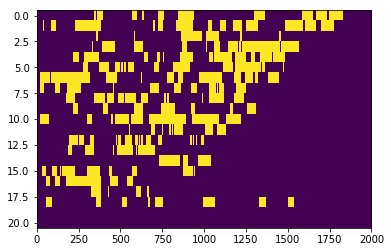

In [9]:
hello = pixel_process(file_process('mm10_cellexpression.csv'))
im = plt.imshow(hello, aspect = 'auto')

In [10]:
def vectorize(file):
    return np.ndarray.flatten(file_process(file))

def vectorize_all(files):
    result = []
    for file in files:
        result.append(vectorize(file))
    return result

In [11]:
def elasticnet(files, transparency2):
    data = pd.DataFrame(np.transpose(vectorize_all(files)), columns = files)
    target = np.ndarray.flatten(transparency2)
    scaler = StandardScaler()
    data_std = scaler.fit_transform(data)
    data_std = pd.DataFrame(data_std, columns = files)
    X_train, X_test, y_train, y_test = train_test_split(data_std, target, test_size=0.30)
    return linear_model.ElasticNetCV().fit(X_train, y_train)

In [12]:
def process(files, transparency):
    zeros = np.zeros(targetshape)
    processed = []
    for file in files:
        if type(file) == np.ndarray:
            processed.append(zeros)
        else:
            result = pixel_process(file_process(file))
            processed.append(result)
    while len(processed) < 3:
        processed.append(zeros)
    processed.append(transparency)
    return np.array(processed)

In [13]:
def length_hist(files):
    labels = ['eccdna'] + compare_names
    
    fig = plt.figure()
    fig.set_size_inches(10,8)
    bins = np.linspace(0, 9000, 100)
    for file in files:
        plt.hist(file.length, bins, edgecolor='black', linewidth=1.2, alpha = 0.5, label = labels.pop(0))
    plt.legend(loc='upper right')
    plt.xlabel('eccdna length in bp')
    plt.tight_layout()

In [14]:
def map_regression_plot(transparency):
    f , ax = plt.subplots(1, 2)
    f.suptitle('Co-occurance of eccdna with various DNA patterns', y=1.0)
    f.set_size_inches(20,8)
    labels = [f"chr{x}" for x in (list(range(1,20)) + ["X","Y"])]

    imaget = np.array(process(files, transparency))
    image = imaget.transpose([1,2,0])

    plt.sca(ax[0])
    ax[0].set_yticks(range(21))
    ticks = ax[0].set_yticklabels(labels)
    ax[0].set_title('Co-occurance of eccdna with all 3 DNA patterns')
    im = plt.imshow(image, aspect = 'auto')

    values = elasticnet(files, transparency).coef_
    values = ['%.2f' % elem for elem in values]
    values = list(map(float, values))

    color = ['red', 'green', 'blue']
    df = np.transpose(pd.DataFrame(np.array([values, files, color])))
    df = df.rename(columns = {0:'coef_value', 1:'dataset', 2:'color'})
    df = df.sort_values('coef_value', ascending = False)
        
    plt.sca(ax[1])
    plt.bar(list(range(1, len(df.dataset)+1)), [float(x) for x in df.coef_value], color = df.color)
    ax = plt.gca()
    ax.set_title('Datasets sorted by coefficient calculation from Elastic Net Model')
    ax.set_xticks(range(1, 4))
    plt.ylim(bottom=0)
    ticks = ax.set_xticklabels(df.dataset)
    
#     ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#     labels = [item.get_text() for item in ax.get_yticklabels()]
#     ax.set_yticklabels([str(round(float(label), 2)) for label in labels if label!=''])

    plt.tight_layout()

In [15]:
def feature_cor_plot(allfiles):
    data = pd.DataFrame(np.transpose(vectorize_all(allfiles)), columns = allfiles).transpose()
    corr = np.corrcoef(data)
    fig = plt.figure()
    labels = [x[5:-4] for x in data.index]
    corrmap = sns.heatmap(corr, xticklabels=labels, yticklabels=labels)


In [16]:
def eccdna_cor_plot(pixels):
    flattened = []
    for pixel in pixels:
        flattened.append(np.ndarray.flatten(pixel_process(pixel)))
        
    data = pd.DataFrame(np.transpose(flattened), columns = ['eccdna', 'heart', 'liver', 'brain']).transpose()
    corr = np.corrcoef(data)
    fig = plt.figure()
    labels = ['eccdna', 'heart', 'liver', 'brain']
    corrmap = sns.heatmap(corr, xticklabels=labels, yticklabels=labels, cmap = 'plasma')

In [17]:
def compare_pixelate(compare_df):
    compare_df['mid100k'] = (compare_df[['start','end']].mean(axis = 1))//1e5
    compare_array = pd.concat([compare_df.chrom.apply(xvalue).rename('x'), 
                       compare_df.mid100k.rename('y'), compare_df.abundance], axis = 1)
    compare_array['abundance1'] = compare_array.groupby(['x', 'y']).transform('count')
    compare_array['abundance'] = compare_array['abundance'] + compare_array['abundance1']
    compare_array = compare_array.drop('abundance1', 1)
    compare_array = compare_array.drop_duplicates(['x', 'y'])
    return compare_array.pivot(index='x', columns='y', values='abundance').fillna(0)
    

In [25]:
def compare_dfmaker(file):
    compare_path = os.path.join(COMPARE_DATA_DIR, file)
    compare_df = pd.read_csv(compare_path, delimiter="\t")
    compare_df.columns = ['chrom','start','end','abundance','extra']
    compare_df = compare_df.drop('extra',1)
    compare_df['length'] = compare_df['end'] - compare_df['start']
    return compare_df

In [18]:
def transparent(pixel):
    transparency = (pixel).values
    big_transparency = np.zeros(targetshape)
    big_transparency[0:transparency.shape[0], 0:transparency.shape[1]] = transparency
    return big_transparency

In [19]:
def eccdna_pixelate(loci):
    loci['mid100k'] = (loci[['start','end']].mean(axis = 1))//1e5
    loci_array = pd.concat([loci.chrom.apply(xvalue).rename('x'), 
                       loci.mid100k.rename('y')], axis = 1)
    
    return loci_array.groupby(['x', 'y']).apply(lambda x: x.y.count()).unstack().fillna(0) 

In [23]:
def create_figure(tracks, eccdna, compare_files):
    #Jen's eccdna data
    fpath = os.path.join(JEN_DATA_DIR, eccdna)
    loci = pd.read_csv(fpath, names = ["chrom","start","end"],delimiter="\t")
    loci['length'] = loci['end'] - loci['start']
    pixels = eccdna_pixelate(loci)
    transparency = transparent(pixels)
    
    map_regression_plot(transparency)
    
    #pixel and file accumulators
    correlate_data = [transparency]
    length_hist_data = [loci]
    
    #Shibata comparison data
    for file in compare_files:
        compare_file = compare_dfmaker(file)
        
        length_hist_data.append(compare_file)
        
        compare_pixels = compare_pixelate(compare_file)
        compare_transparency = transparent(compare_pixels)
        
        correlate_data.append(compare_transparency)
        map_regression_plot(compare_transparency)
    
    eccdna_cor_plot(correlate_data)
    length_hist(length_hist_data)
    feature_cor_plot(allfiles)
    
    #     my_dir = os.path.dirname(__file__)
    #     results_dir = os.path.join(my_dir, 'RegResults/')

    #     if not os.path.isdir(results_dir):
    #         os.makedirs(results_dir)

    #plt.savefig(os.path.join(OUT_DIR,"eccdna1_figures_"+CONFIGURATION_NAME)) - only saves last plot.

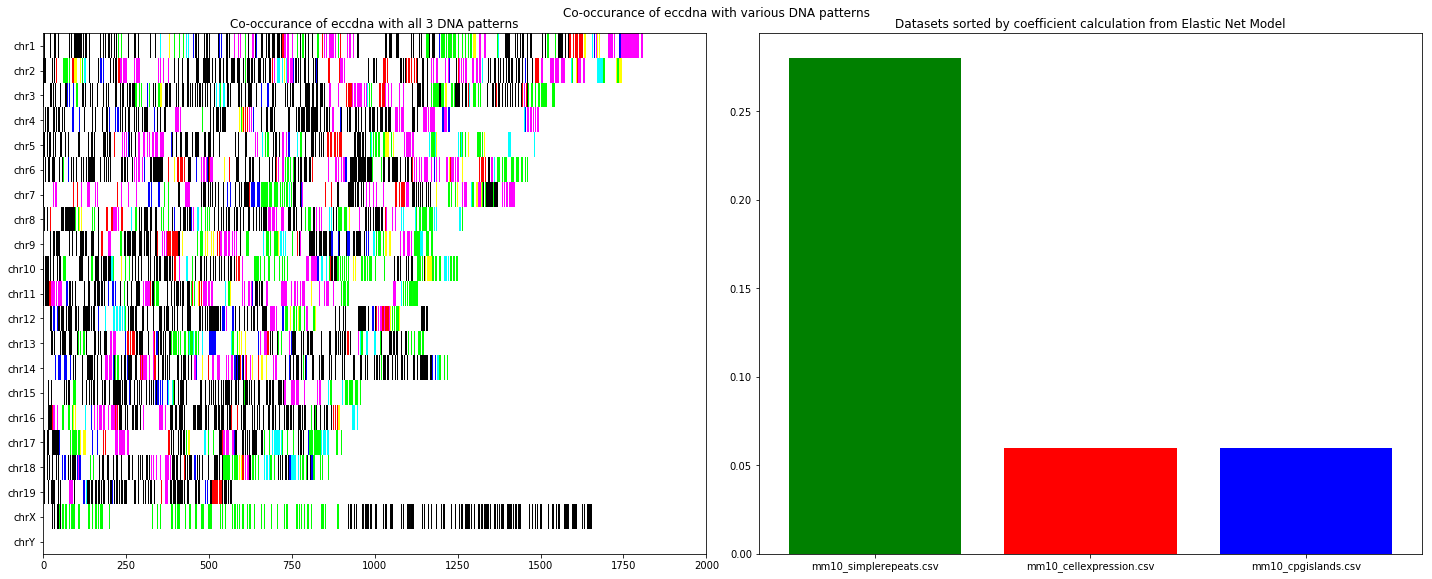

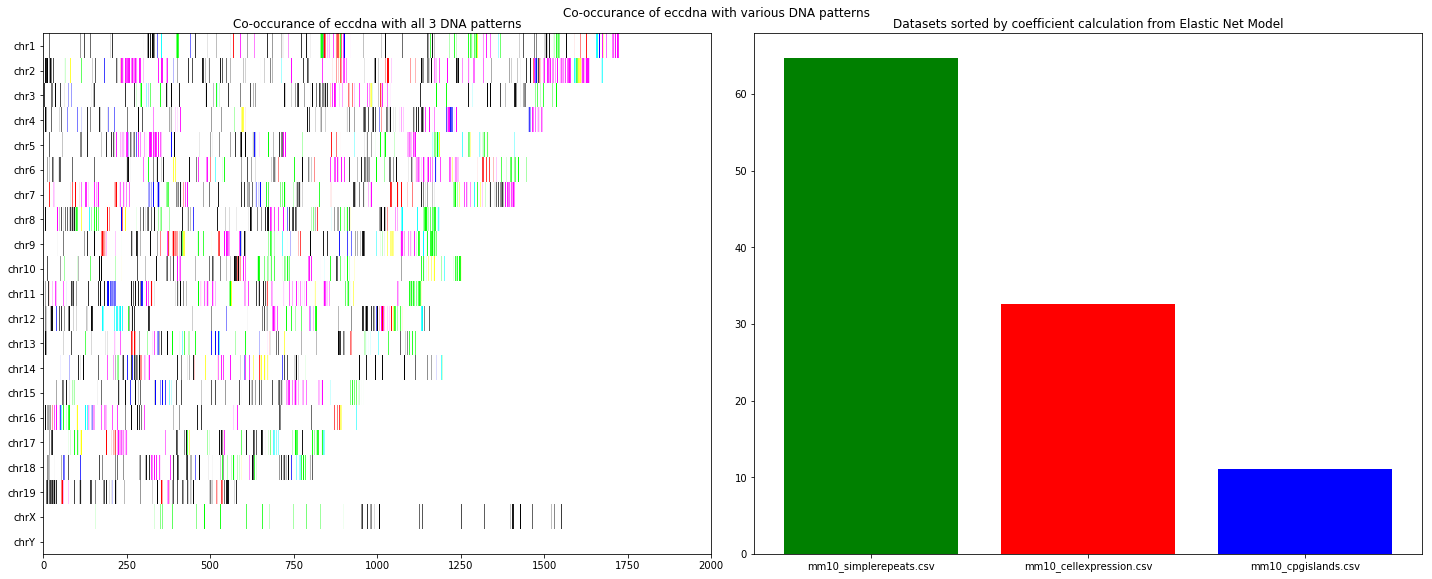

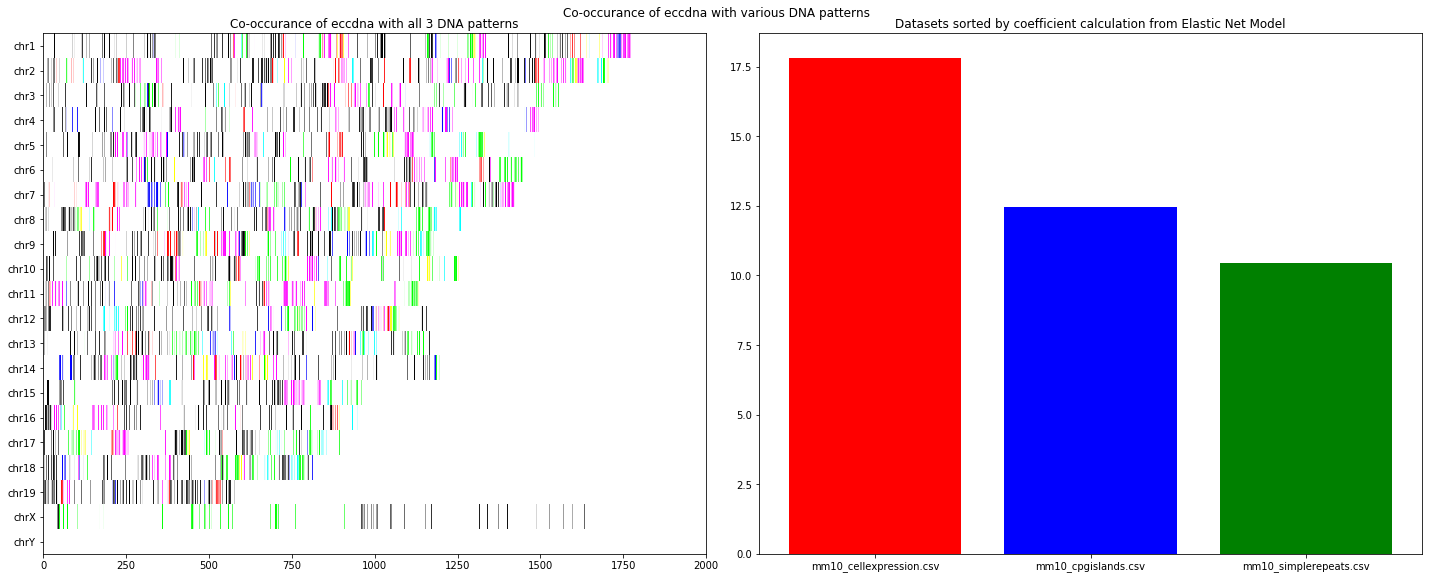

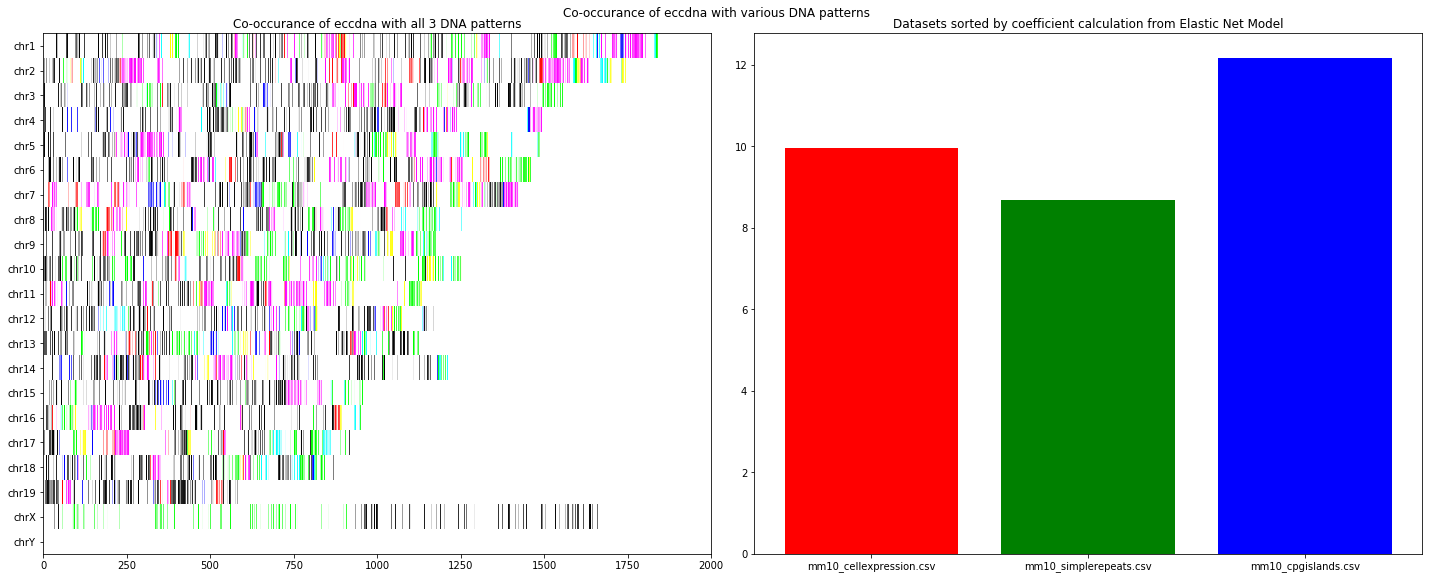

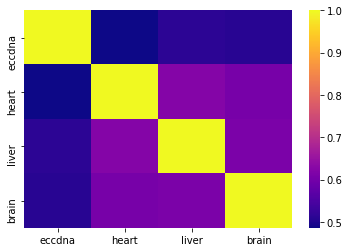

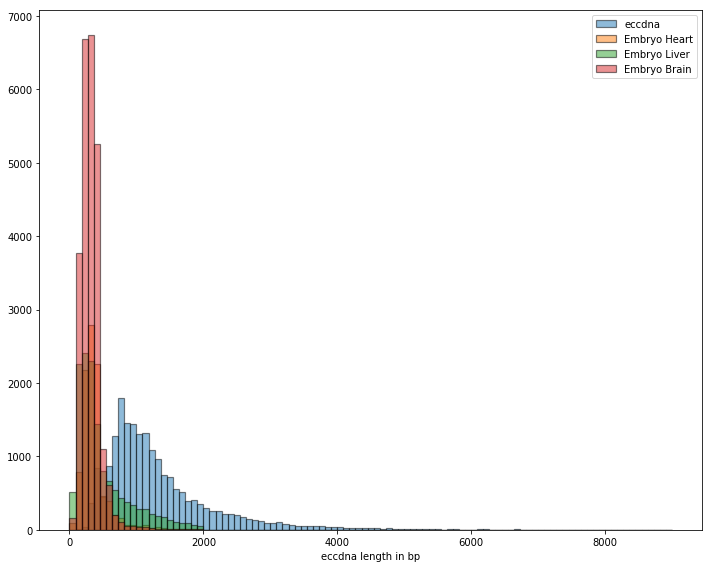

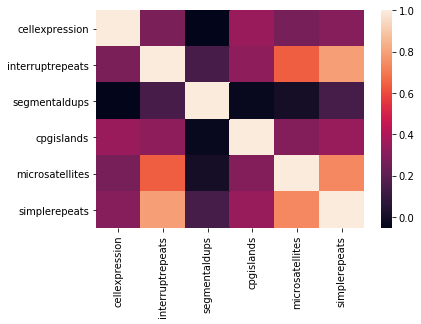

In [26]:
create_figure(REGRESSION_TRACK_FILES, "mid_conf_MN-de.bed", compare_files)

In [ ]:
##
# notice that there are several eccdna files to choose from:
# [high_conf.bed  high_conf_MN-de.bed  low_conf.bed  low_conf_MN-de.bed  mid_conf.bed  mid_conf_MN-de.bed]
## 

#I am loading high confidence Motor Neuron (MN) dnas here:
fpath = os.path.join(JEN_DATA_DIR, "high_conf_MN-de.bed")
loci = pd.read_csv(fpath, names = ["chrom","start","end"],delimiter="\t")

#But you can try the mid_conf_MN-de.bed file too!

the rest is all up to your imagination :)
